# Test latitude masking for percipitation 

- author: Johannes L. Fjeldså
- email: johannes.larsen.fjeldså@nmbu.no

## Import libraries

In [37]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
from xclim import ensembles as ens

from src.preproces import *
from pathlib import Path


file_handler = Handle_Files()

## Plotting 

In [76]:
def plot_on_map(data, ax=None,
                center_lon=0, center_lat=20,
                cmap='viridis',
                title=None, 
                v_min=None,
                v_max=None,
                migrate_colorbar=False):
    """
    Parameters:
    - data (xr.DataArray): The data to be plotted. Horizontal 2D data at a single time step.
    - center_lat (float): The latitude for the center of the plot.
    - center_lon (float): The longitude for the center of the plot.
    - cmap (str or Colormap): The colormap to be used for the plot.
    - title (str): The title of the plot.
    - v_min (float): The minimum value for the colorbar.
    - v_max (float): The maximum value for the colorbar.
    """
    settings = {'transform': ccrs.PlateCarree(),
                'cmap': cmap,
                'vmin': v_min,
                'vmax': v_max}

    if migrate_colorbar:
        settings['add_colorbar'] = False
    else:
        settings['cbar_kwargs'] = {"orientation": "horizontal", "shrink": 0.7}
        settings['robust'] = True
    
    if ax is not None:
        settings['ax'] = ax
    else:    
        settings['subplot_kws'] = dict(projection=ccrs.Robinson(central_longitude=center_lon), facecolor="gray")

    p = data.plot(**settings)
        
    p.axes.set_global()
    p.axes.coastlines()

    if title is None:
        title = "Map plot"
    if ax is None:
        plt.title(title)

        plt.show()
    else:
        ax.set_title(title)


In [30]:
def disp_external_fig(path_to_image, wanted_height=None, wanted_width=None):
    img = plt.imread(path_to_image)

    if wanted_height is not None and wanted_width is not None:
        height = wanted_height
        width = wanted_width
    
    elif wanted_height is not None:
        height = wanted_height
        width = int(height * img.shape[1] / img.shape[0])
        
    elif wanted_width is not None:
        width = wanted_width
        height = int(width * img.shape[0] / img.shape[1])
    else:
        height = img.shape[0]
        width = img.shape[1]

    
    plt.figure(figsize=(width, height))
    plt.imshow(img)
    plt.axis('off')  # to turn off the axis labels
    plt.show()


## Create file-compatible masking

### Identify regions to mask 

The global masking of percipitation with intermask meanscaling is shown bellow. 

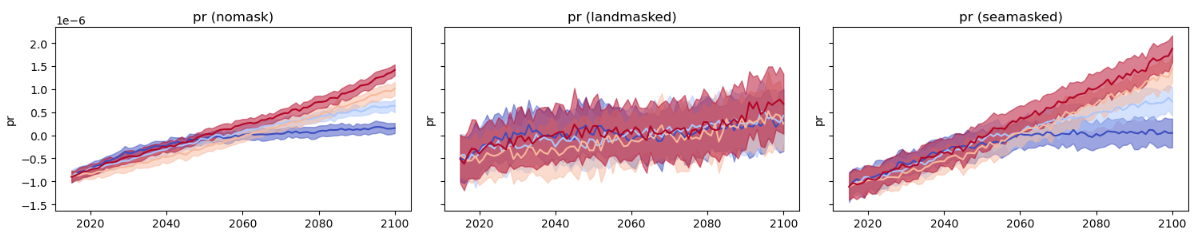

For early emerging signal this is quite unusable since the ensambles are at large overlapping as well as the means being close. Examining the [ipcc interactive atlas](https://interactive-atlas.ipcc.ch/regional-information#eyJ0eXBlIjoiQVRMQVMiLCJjb21tb25zIjp7ImxhdCI6LTMwNzYzOTAsImxuZyI6MjMxNzIzLCJ6b29tIjozLCJwcm9qIjoiRVBTRzo1NDAzMCIsIm1vZGUiOiJjb21wbGV0ZV9hdGxhcyJ9LCJwcmltYXJ5Ijp7InNjZW5hcmlvIjoic3NwMTI2IiwicGVyaW9kIjoibmVhciIsInNlYXNvbiI6InllYXIiLCJkYXRhc2V0IjoiQ01JUDYiLCJ2YXJpYWJsZSI6InByIiwidmFsdWVUeXBlIjoiUkVMQVRJVkVfQU5PTUFMWSIsImhhdGNoaW5nIjoiU0lNUExFIiwicmVnaW9uU2V0IjoiYXI2IiwiYmFzZWxpbmUiOiJwcmVJbmR1c3RyaWFsIiwicmVnaW9uc1NlbGVjdGVkIjpbXX0sInBsb3QiOnsiYWN0aXZlVGFiIjoicGx1bWUiLCJtYXNrIjoibm9uZSIsInNjYXR0ZXJZTWFnIjpudWxsLCJzY2F0dGVyWVZhciI6bnVsbCwic2hvd2luZyI6ZmFsc2V9fQ==) with the %-change of the total percipititaion (*pr*) variable agregated from CMIP6 model ensambles we get the figs shown bellow


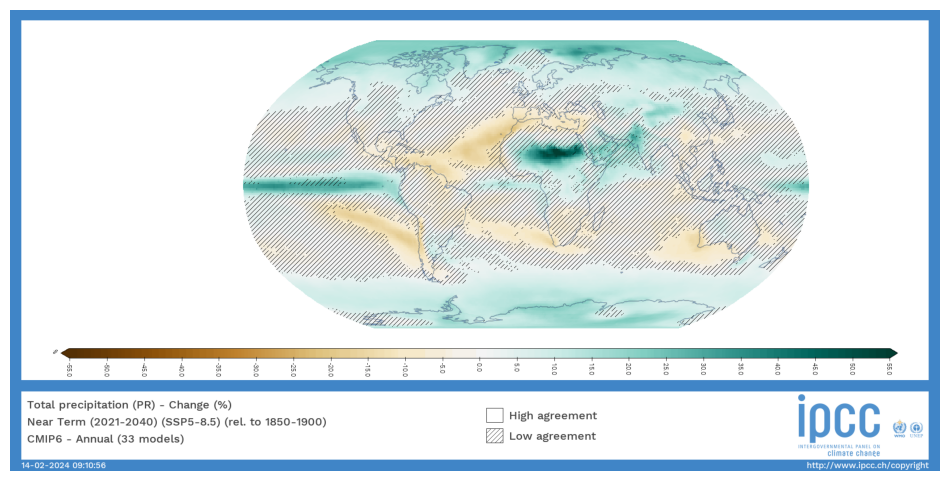

In [24]:
disp_external_fig('/nird/home/johannef/Masterthesis_S23/External figs/CMIP6 - Total precipitation (PR) Change % - Near Term (2021-2040) SSP5-8.5 (rel. to 1850-1900) - Annual (33 models).png',
                  wanted_height=6)

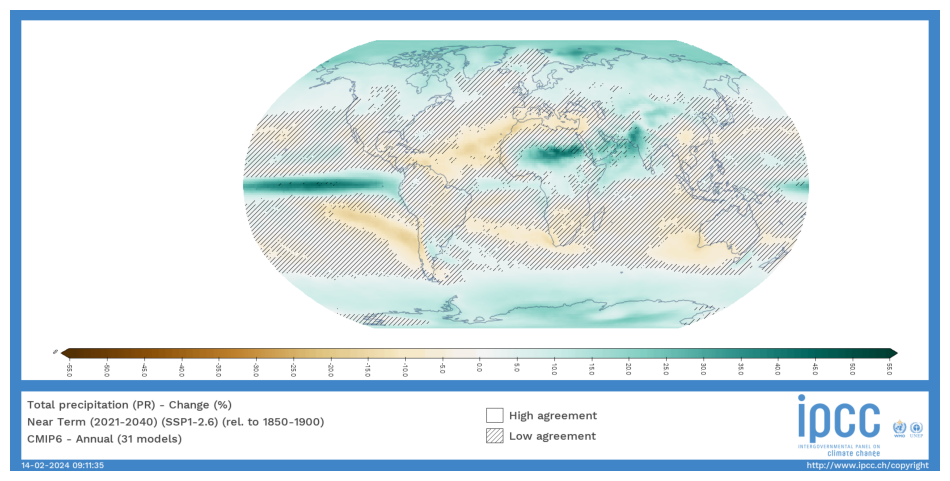

In [27]:
disp_external_fig('/nird/home/johannef/Masterthesis_S23/External figs/CMIP6 - Total precipitation (PR) Change % - Near Term (2021-2040) SSP1-2.6 (rel. to 1850-1900) - Annual (31 models).png',
                  wanted_height=6)

From these figs it seems to be a good starting point to investigete around the equator $\pm 30 ^\circ$. It is inportant to note that the scrambled areas are areas with low model agreement, in our model there will be a signal in these areas as well. 

In order to actually investigate areas with stronger diverging signals we will plot the inter SSP anamonlies of the SSP-ensamblemean from the annual climatologies.

In [40]:
main_data_folder = '/nird/home/johannef/Masterthesis_S23 DataFiles/Annualclimatologies/nomask/pr'
SSPs = ['ssp126', 'ssp245', 'ssp370', 'ssp585']

ensambles = {scenario: ens.create_ensemble(Path(main_data_folder + '/' + scenario).glob("*.nc")) for scenario in SSPs}
ensambles['ssp126'].pr

<xarray.DataArray 'pr' (realization: 40, year: 86, lat: 145, lon: 192)>
dask.array<concatenate, shape=(40, 86, 145, 192), dtype=float32, chunksize=(1, 86, 145, 192), chunktype=numpy.ndarray>
Coordinates:
  * lon          (lon) float64 0.0 1.875 3.75 5.625 ... 352.5 354.4 356.2 358.1
  * lat          (lat) float64 -90.0 -88.75 -87.5 -86.25 ... 87.5 88.75 90.0
  * year         (year) int64 2015 2016 2017 2018 2019 ... 2097 2098 2099 2100
  * realization  (realization) int64 0 1 2 3 4 5 6 7 ... 32 33 34 35 36 37 38 39
Attributes:
    standard_name:  precipitation_flux
    long_name:      Precipitation
    units:          kg m-2 s-1
    comment:        includes both liquid and solid phases
    cell_methods:   area: time: mean
    cell_measures:  area: areacella

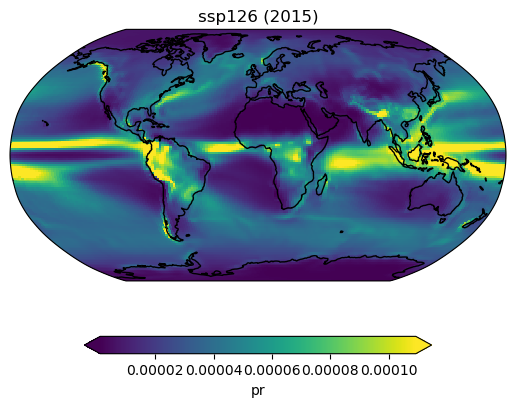

In [77]:
data = ensambles['ssp126'].sel(year=2015).mean(dim='realization').pr
plot_on_map(data, title="ssp126 (2015)")

In [ ]:
fig, axs = plt.subplots(4, 4, figsize=(20, 20), subplot_kw=dict(projection=ccrs.Robinson(central_longitude=0), facecolor="gray"))
    for row, year in enumerate([2015, 2025, 2035, 2045]):
        ax = axs[row, 0]
        plot_on_map(scenario_data, ax=ax, title=f"{scenario} ({year})")

        for col, other_scenario in enumerate(other_scenarios, start=1):
            data = scenario_data - ensambles[other_scenario].sel(year=year).mean(dim='realization').pr
            plot_on_map(data, ax=axs[row, col], 
                        title=f"{scenario} - {other_scenario} ({year})", 
                        cmap='BrBG',
                        migrate_colorbar=True)
    
    plt.tight_layout()    
    plt.show()

In [87]:
all_plot_data = {}
scenario_max = -np.inf
anamoly_min = np.inf
anamoly_max = -np.inf

for scenario in SSPs:
    other_scenarios = [ssp for ssp in SSPs if ssp != scenario]
    scenario_plot_data = {2015: {}, 2025: {}, 2035: {}, 2045: {}}
    
    for year in list(scenario_plot_data.keys()):
        scenario_data = ensambles[scenario].sel(year=year).mean(dim='realization').pr
        scenario_plot_data[year][scenario] = scenario_data
        
        if scenario_data.values.max() > scenario_max:
            scenario_max = scenario_data.values.max()

        for other_scenario in other_scenarios:
            data = scenario_data - ensambles[other_scenario].sel(year=year).mean(dim='realization').pr
            scenario_plot_data[year][f'{scenario} - {other_scenario}'] = data
            if data.values.min() < anamoly_min:
                anamoly_min = data.values.min()
            if data.values.max() > anamoly_max:
                anamoly_max = data.values.max()

    all_plot_data[scenario] = scenario_plot_data

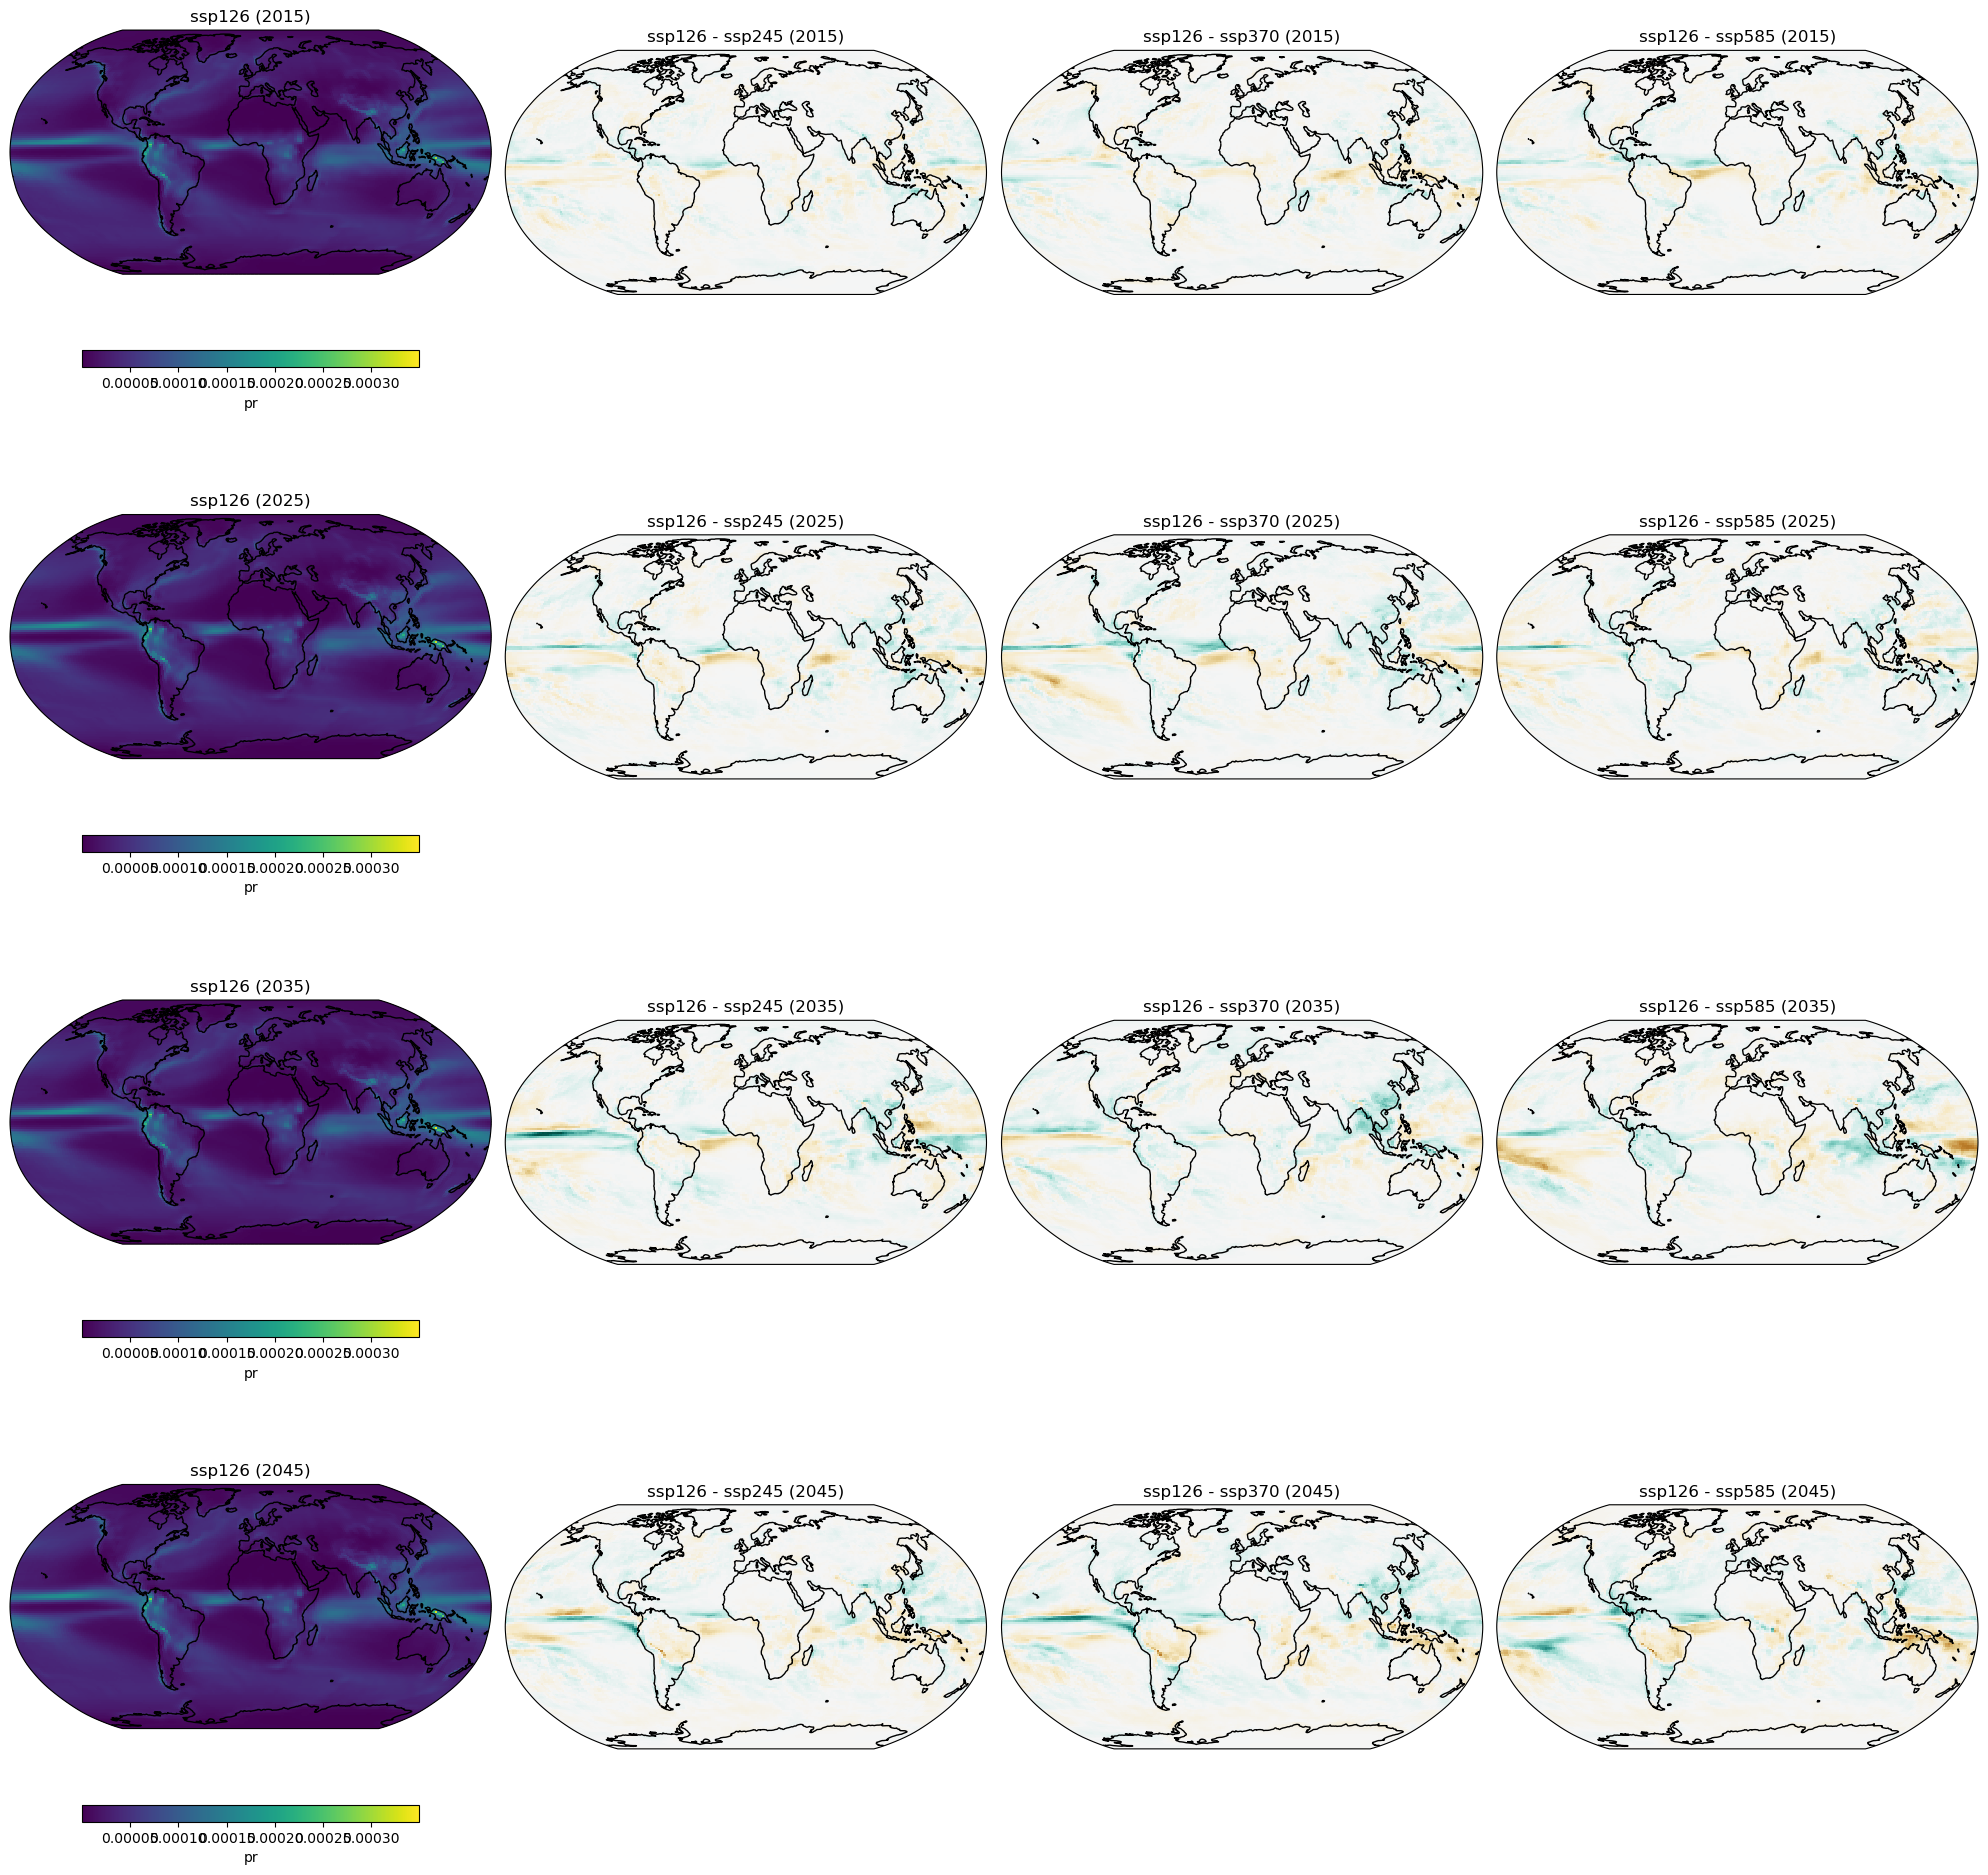

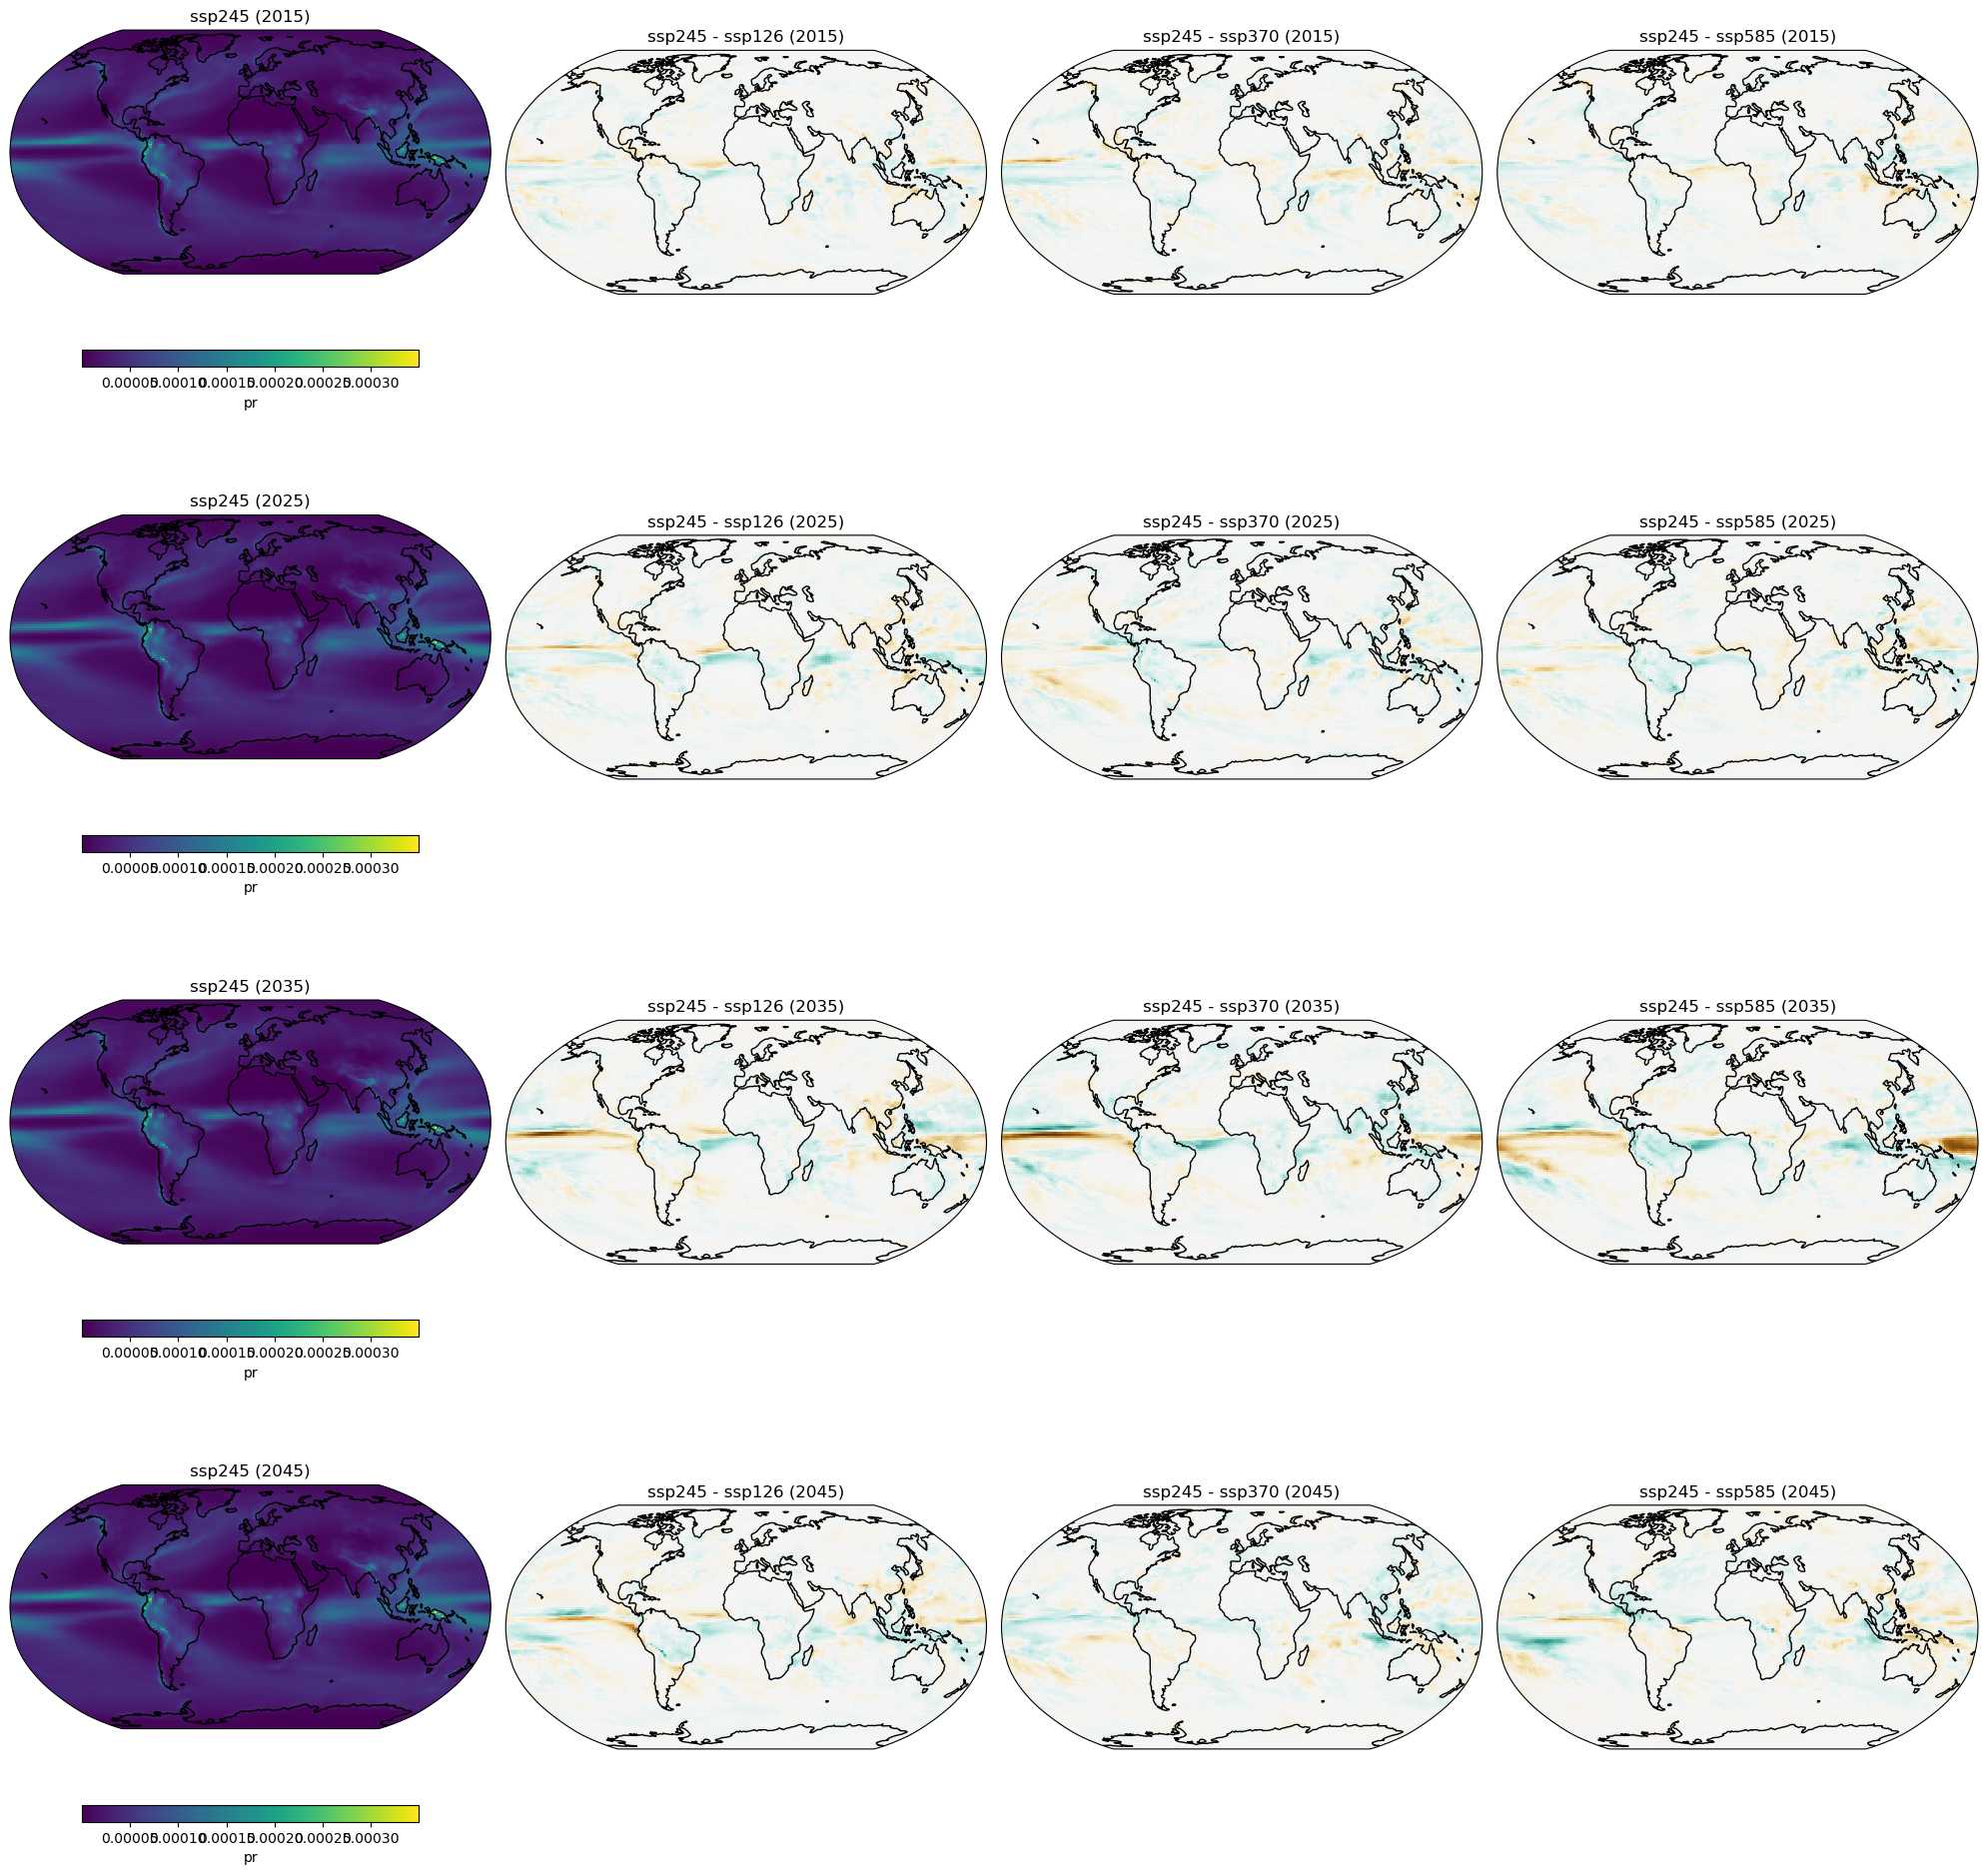

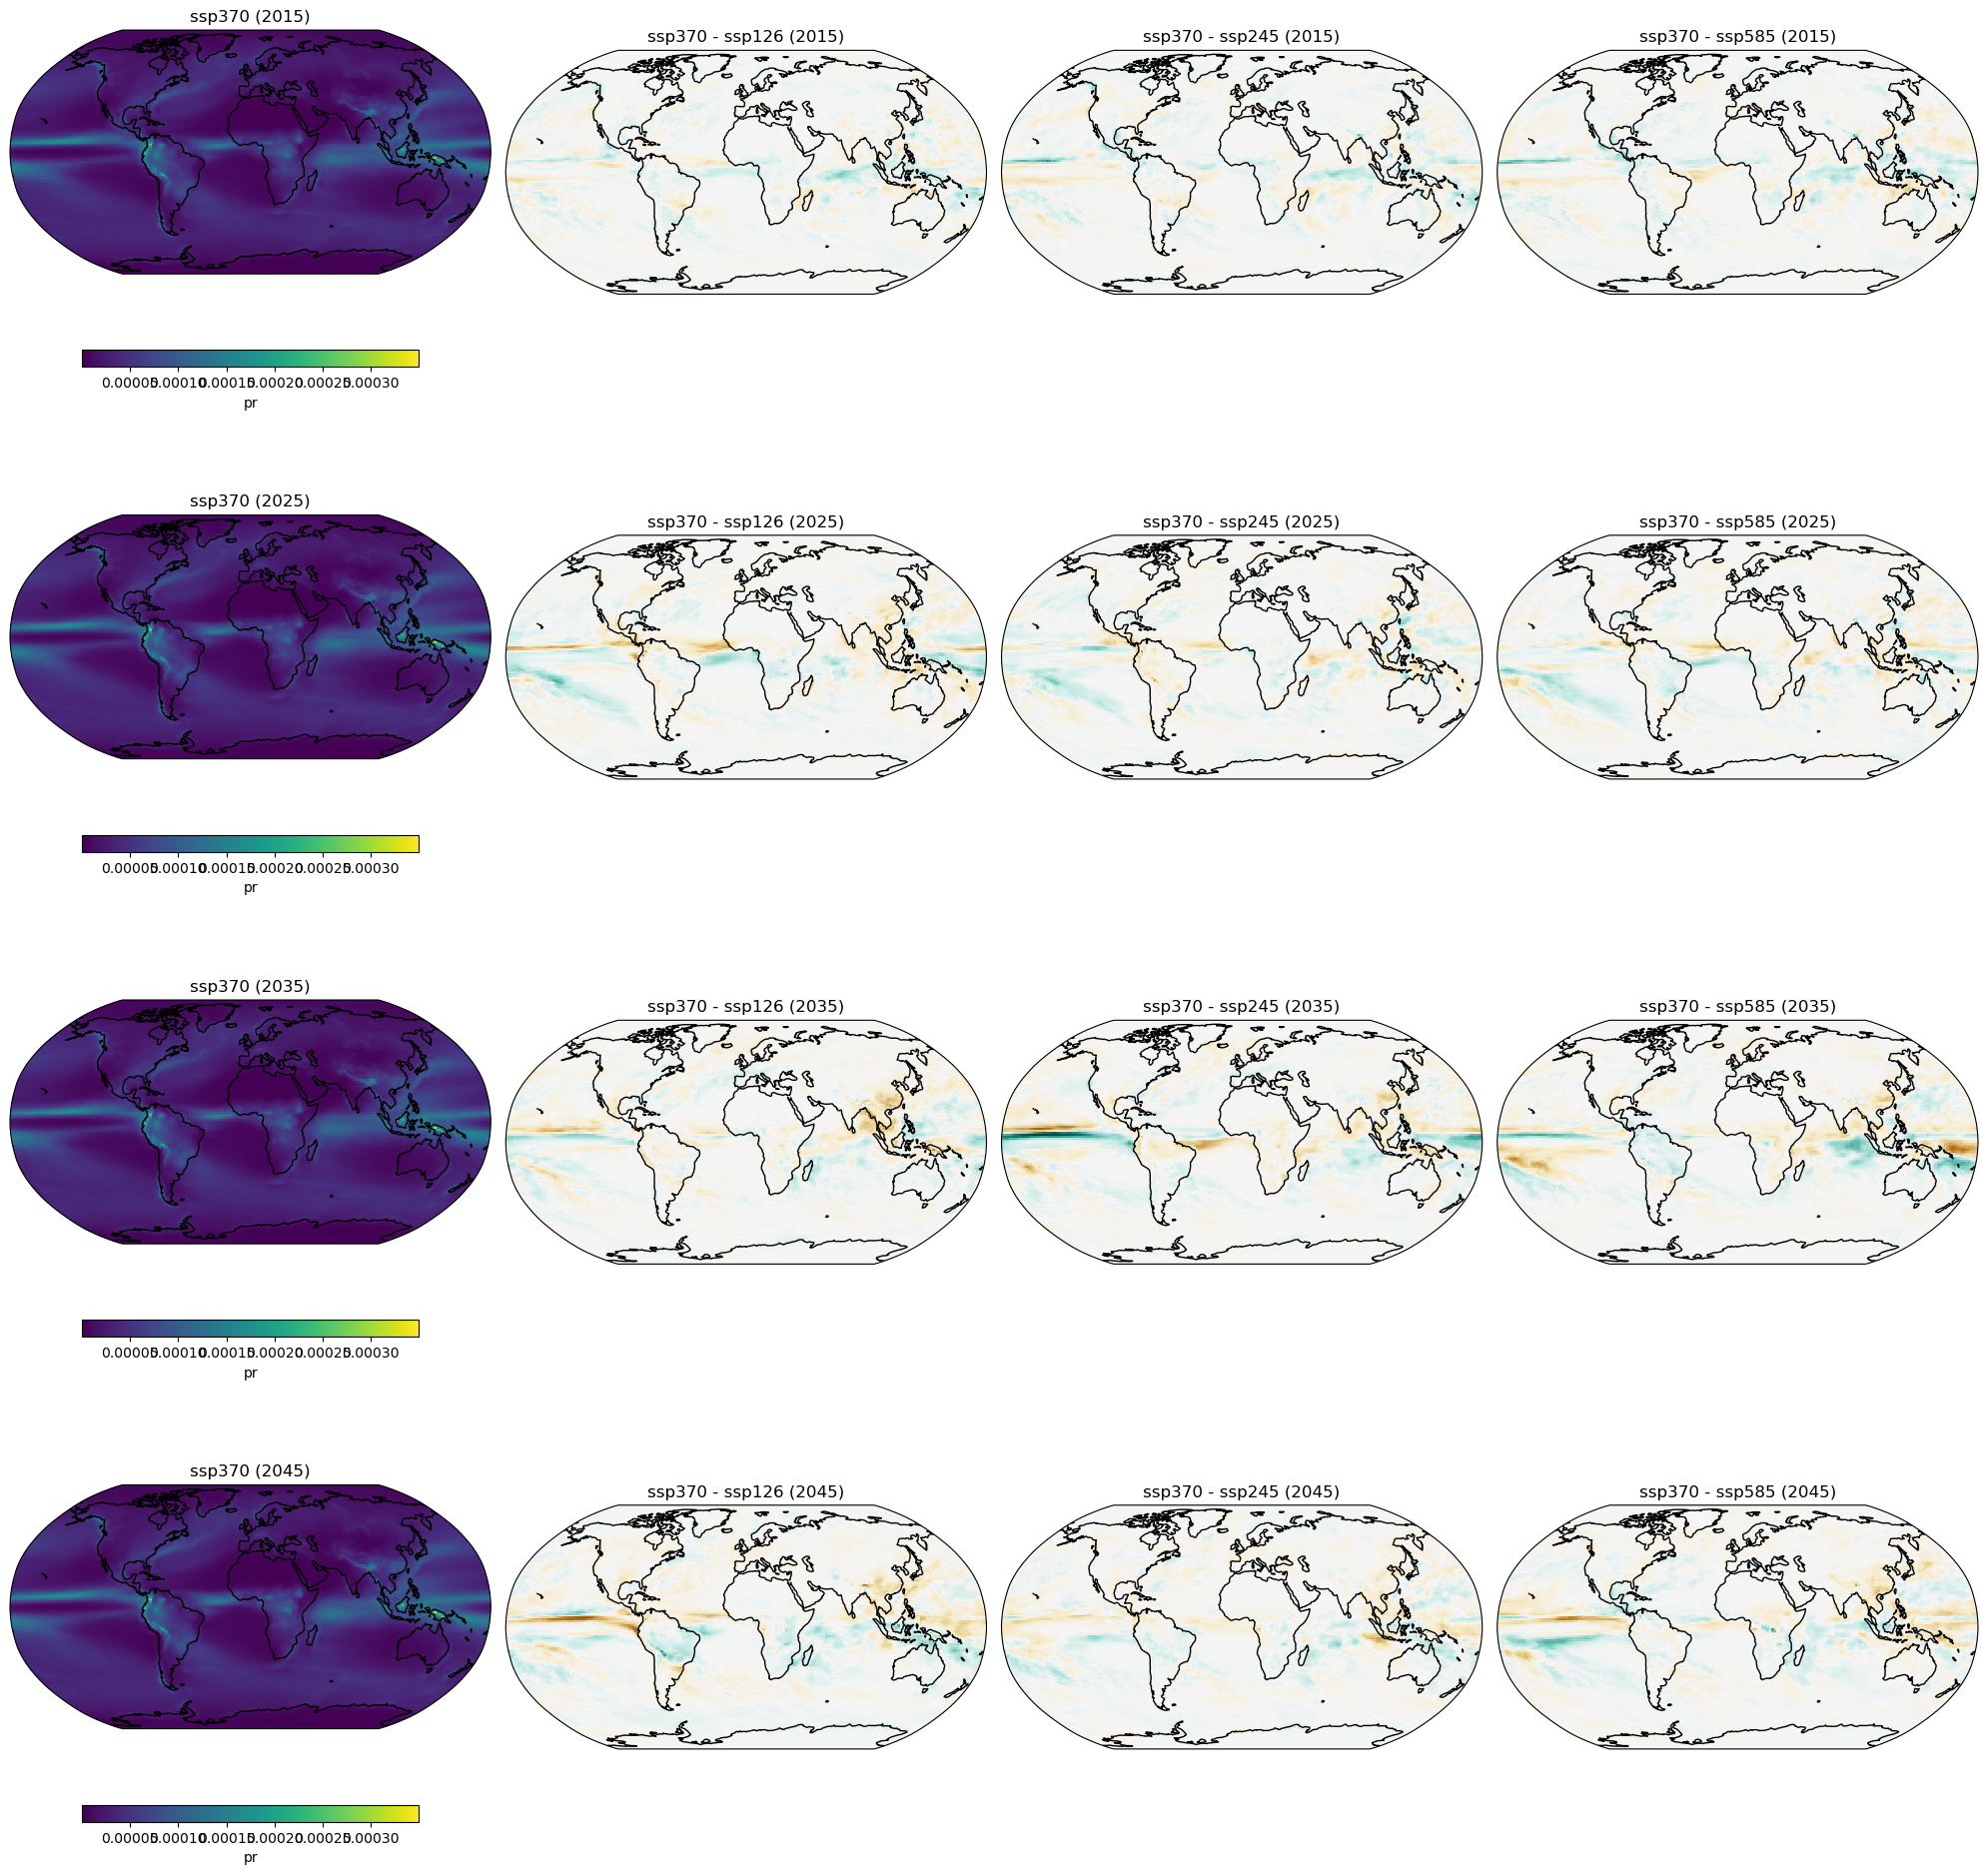

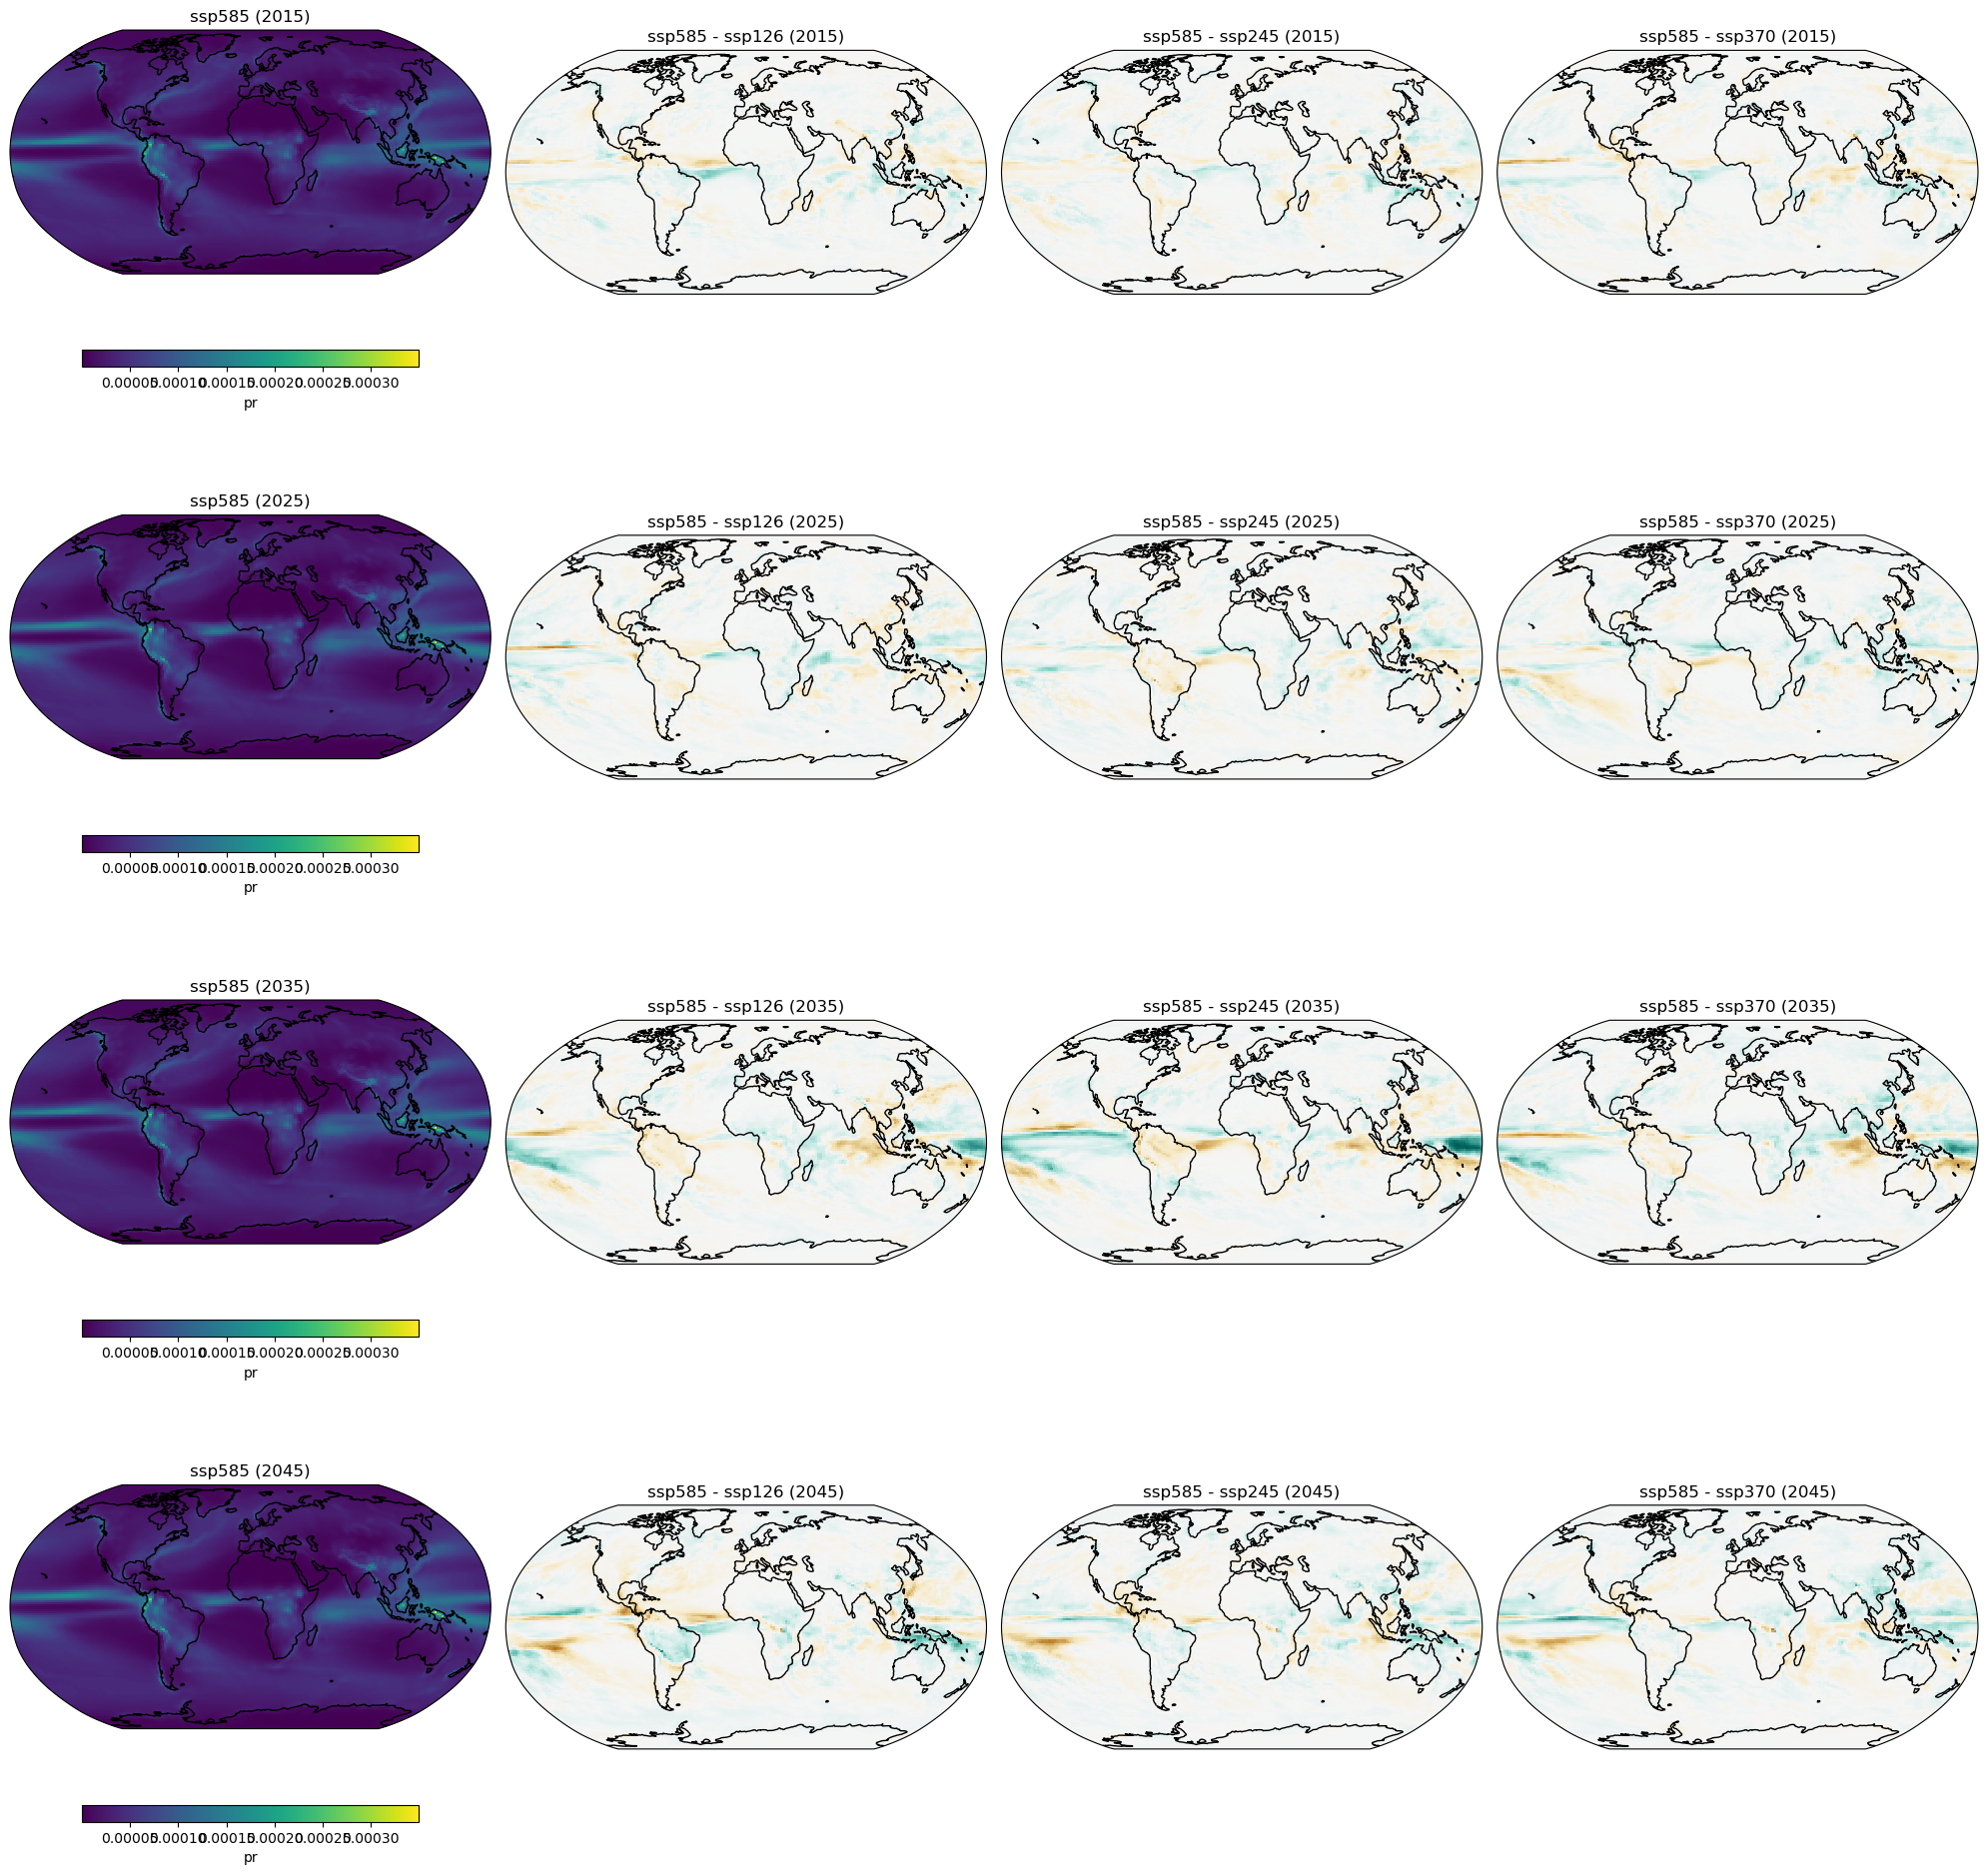

In [92]:
for scenario in SSPs:
    other_scenarios = [ssp for ssp in SSPs if ssp != scenario]
    fig, axs = plt.subplots(4, 4, figsize=(20, 20), subplot_kw=dict(projection=ccrs.Robinson(central_longitude=0), facecolor="gray"))
    
    for row, year in enumerate([2015, 2025, 2035, 2045]):
        ax = axs[row, 0]
        plot_on_map(all_plot_data[scenario][year][scenario], ax=ax, 
                    title=f"{scenario} ({year})", 
                    v_min=0,
                    v_max=scenario_max)

        for col, other_scenario in enumerate(other_scenarios, start=1):
            ax = axs[row, col]
            plot_on_map(all_plot_data[scenario][year][f'{scenario} - {other_scenario}'], ax, 
                        title=f"{scenario} - {other_scenario} ({year})", 
                        v_min=anamoly_min,
                        v_max=anamoly_max,
                        cmap='BrBG',
                        migrate_colorbar=True)
    
    plt.tight_layout()    
    plt.show()